# Network Tour project

This is a notebook to describe the connections between artists and users.

## Analysis on data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import pandas as pd
import os.path
import networkx as nx
import scipy.sparse as sp
import sklearn as skl
import pygsp as gsp
from scipy.sparse import csr_matrix
from Dataset import Dataset
import pickle
%matplotlib inline
from plotly.graph_objs import *

Loading the artists information, user/friend connections, and user/artist listening count.

In [2]:
artists_df = pd.read_csv('artists.dat', sep='\t', header=0,index_col=0, skipinitialspace=True)
user_artist = pd.read_csv('user_artists.dat',sep='\t', header=0, skipinitialspace=True)
user_user = pd.read_csv('user_friends.dat',sep='\t', header=0,  skipinitialspace=True)

In [3]:
artists_df.head()

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
artists_df.isnull().sum()

name            0
url             0
pictureURL    444
dtype: int64

In [5]:
print("Are the artists names unique?" ,artists_df['name'].is_unique)
print("Number of artists in the dataset:", len(artists_df))

Are the artists names unique? True
Number of artists in the dataset: 17632


In [6]:
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [7]:
user_artist.isnull().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [8]:
user_user.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [9]:
user_user.isnull().sum()

userID      0
friendID    0
dtype: int64

In [10]:
max_user_weight = user_artist.groupby('userID').max()
max_user_weight.describe()

,artistID,weight
count,1892.000000,1892.000000
mean,10749.308668,8854.966173
std,4882.704028,23090.244867
min,89.000000,1.000000
25%,6853.750000,1059.500000
50%,11039.500000,2690.000000
75%,14899.250000,6928.500000
max,18745.000000,352698.000000


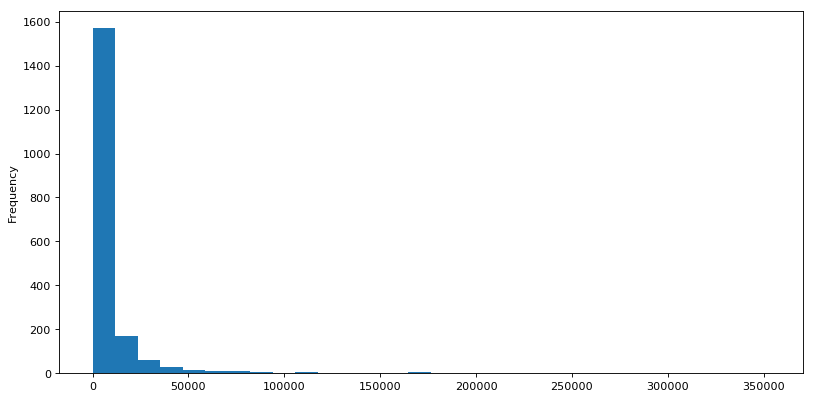

In [11]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
max_user_weight['weight'].plot.hist(bins=30)

We can see from the plot above that most of the users have a maximum listening count of less than 50,000.

In [12]:
print("The number of users with less than a maximum of 50,000 listening count:",\
      len(max_user_weight.loc[max_user_weight['weight']<=50000]))
percentage = len(max_user_weight.loc[max_user_weight['weight']<=50000])/ len(max_user_weight)*100
print("Percentage of total users:", \
     percentage ,"%")

The number of users with less than a maximum of 50,000 listening count: 1833
Percentage of total users: 96.8816067653277 %


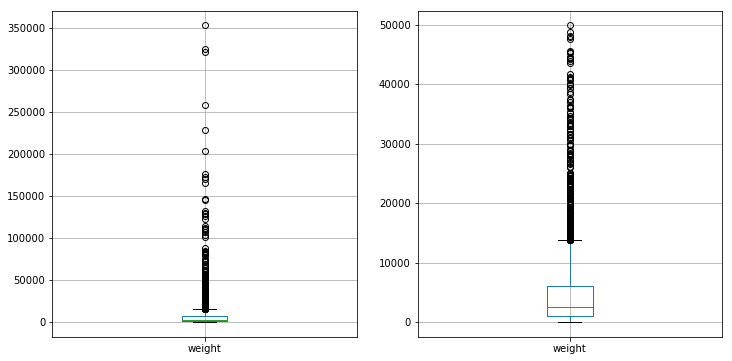

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
max_user_weight.boxplot(column='weight')
plt.subplot(1,2,2)
max_user_weight.loc[max_user_weight['weight']<=50000].boxplot(column='weight')

In [14]:
user_user.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [15]:
print("Number of users in the dataset:", len(set(user_user.userID.values)))
print("Number of edges between users: " ,int(len(user_user)/2))

Number of users in the dataset: 1892
Number of edges between users:  12717


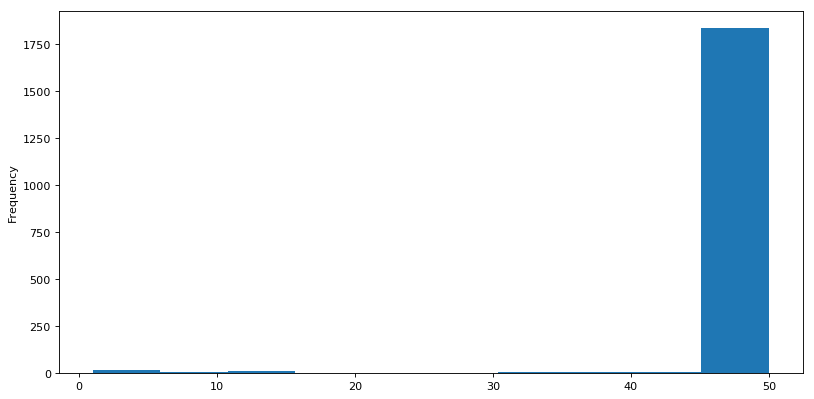

In [16]:
number_user_artist = user_artist.groupby('userID').nunique().artistID.to_frame()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
number_user_artist['artistID'].plot.hist(bins=10)

We can clearly see that most of the users have between 45 and 50 artists, in fact a further analysis shows that most of those users have exactly 50 artists. To make the data more consistent, we will only use those.

In [17]:
print("The number of users with exactly 50 artists: ",\
      len(number_user_artist.loc[number_user_artist['artistID']==50]))
percentage = len(number_user_artist.loc[number_user_artist['artistID']==50])/ len(number_user_artist)*100
print("Percentage of those users:", \
     percentage ,"%")

The number of users with exactly 50 artists:  1829
Percentage of those users: 96.67019027484145 %


Number of connections of each artist.

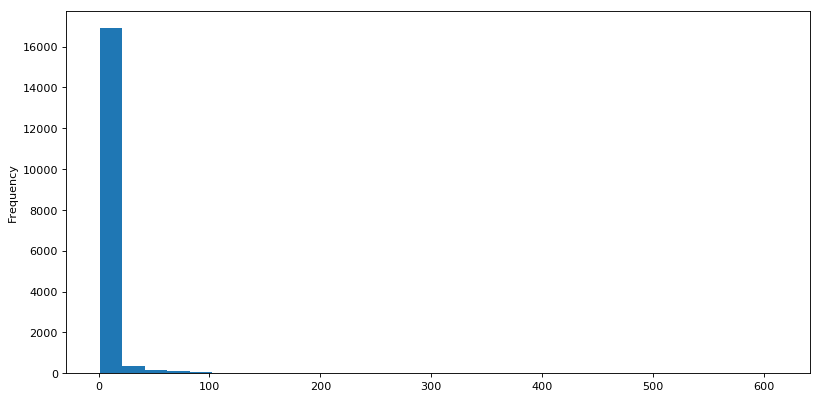

In [18]:
number_artist_user = user_artist.groupby('artistID').nunique().userID.to_frame()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
number_artist_user['userID'].plot.hist(bins=30)

In [19]:
print("The number of artists in the dataset: ", len(number_artist_user))
print("The number of artists with less than 50 user connections:", \
      len(number_artist_user[number_artist_user['userID']<50]))
percentage = len(number_artist_user[number_artist_user['userID']<50]) / len(number_artist_user) *100
print("Percentage of those artists :", \
     percentage ,"%")

The number of artists in the dataset:  17632
The number of artists with less than 50 user connections: 17309
Percentage of those artists : 98.16810344827587 %


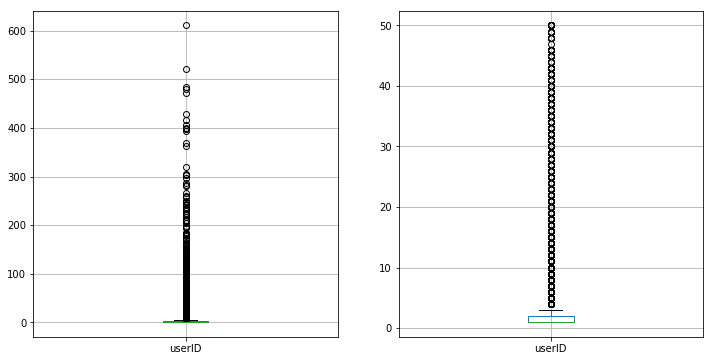

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
number_artist_user.boxplot(column='userID')
plt.subplot(1,2,2)
number_artist_user.loc[number_artist_user['userID']<=50].boxplot(column='userID')

In [21]:
len(number_artist_user.loc[number_artist_user['userID']==1])

10679

In [22]:
user_user_group = user_user.groupby('userID').nunique().friendID.to_frame()

Distribution of the number of friends each user have.

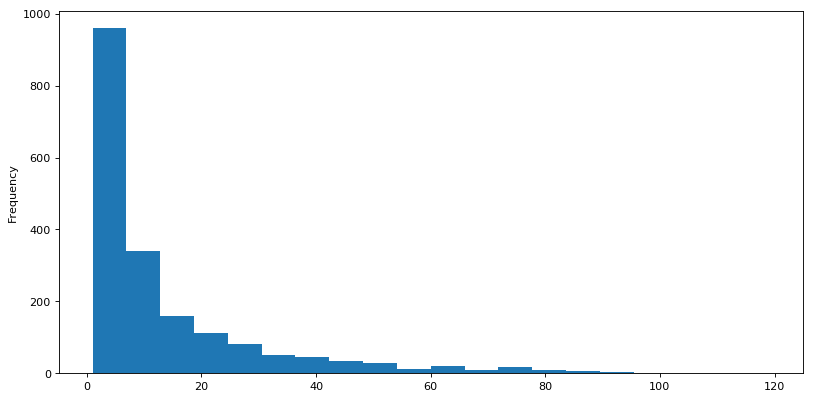

In [23]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
user_user_group['friendID'].plot.hist(bins=20)

In [24]:
len(user_user_group[user_user_group['friendID']>=5])

1131

## User-User Network

In [25]:
users_to_drop = set()

# Group ratings based on users
group = user_artist.groupby('userID')

# Drop users with too high max weight (looking at the distribution
# they seems to be outliers)
data = group.max()
users_to_drop.update(data[data.weight > 50000].index)

# Drop users with few artists
data = group.nunique().artistID
users_to_drop.update(data[data < 49].index)

print(len(users_to_drop), ' users dropped')

117  users dropped


In [26]:
user_artist_ref = user_artist[~user_artist.userID.isin(users_to_drop)]
user_user_ref = user_user[~user_user.userID.isin((users_to_drop))]
user_user_ref = user_user_ref[~user_user_ref.friendID.isin(users_to_drop)]

first_users = set(user_user_ref.userID.values)
users_in_artists = set(user_artist_ref.userID.values)
difference_in_users = list(users_in_artists - first_users)

print("Number of users not in our user network:", len(difference_in_users))

user_artist_ref = user_artist_ref[~user_artist_ref.userID.isin(difference_in_users)]
user_user_ref = user_user_ref[~user_user_ref.userID.isin((difference_in_users))]
user_user_ref = user_user_ref[~user_user_ref.friendID.isin(difference_in_users)]

# Update ID translator dictionaries
userID2POS = {i:p for p,i in enumerate(set(user_artist_ref.userID))}
userPOS2ID = {p:i for p,i in enumerate(set(user_artist_ref.userID))}

Number of users not in our user network: 26


In [27]:
friend_friend = np.zeros((len(userID2POS),len(userID2POS)))
for index, row in user_user_ref.iterrows():
    upos1 = userID2POS[row.userID]
    upos2 = userID2POS[row.friendID]
    friend_friend[upos1,upos2] = 1

In [28]:
len(user_user_ref)/2

10741.0

In [29]:
sum(sum(i > 0 for i in friend_friend))/2

10741.0

## Artist-Artist Network

In [30]:
artist_artist = pd.read_csv('artist_artist_connections.csv', sep='\t', header=0, index_col=0, skipinitialspace=True)

In [31]:
artist_set = set(artist_artist.Artist.values)
artist_in_dataset = artist_artist[artist_artist['Similar_artists'].isin(list(artist_set))]

artist_names = set(artist_in_dataset.Artist.unique())
similar_artist_names = set(artist_in_dataset.Similar_artists.unique())
union_artists = list(artist_names.union(similar_artist_names))

test_ids = []
for i,artist_name in enumerate(union_artists):
    temp_id = [artists_df[artists_df['name'] == artist_name].index.values[0]]
    test_ids.extend(temp_id)
    
artists_id = pd.DataFrame(np.nan, index=test_ids, columns=['Similar_artists'])
artists_id['Similar_artists'] = union_artists
artists_id = artists_id.reset_index()
artists_id.columns=['Artist_id','Similar_artists']

merged_ids = pd.merge(artist_in_dataset,artists_id,on='Similar_artists')

artistID2POS = {i:p for p,i in enumerate(artists_id.Artist_id)}
artistPOS2ID = {p:i for p,i in enumerate(artists_id.Artist_id)}

In [32]:
reduced_artist_artist_matrix = csr_matrix((len(artistID2POS), len(artistID2POS)),dtype = float)
for index, row in merged_ids.iterrows():
    upos1 = artistID2POS[row.ArtistID]
    upos2 = artistID2POS[row.Artist_id]
    reduced_artist_artist_matrix[upos1,upos2] = row.Weight
    reduced_artist_artist_matrix[upos2,upos1] = row.Weight

/home/mezo/anaconda3/envs/Network_tour/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [33]:
reduced_artist_artist_matrix.shape

(13106, 13106)

In [34]:
len(merged_ids.Artist.unique())

12744

In [35]:
len(np.where(reduced_artist_artist_matrix.sum(axis=1)==0)[0])

0

In [36]:
np.nonzero(reduced_artist_artist_matrix-reduced_artist_artist_matrix.transpose())

(array([], dtype=int32), array([], dtype=int32))

## User-Artist Network

In [ ]:
user_artist_ref.head()

Normalizing the weights.

In [ ]:
group_user_artist = user_artist_ref[['userID', 'weight']].groupby('userID')
tots = group_user_artist.max().weight.to_dict()

In [ ]:
user_artist_ref.weight = user_artist_ref.weight / [tots[u] for u in user_artist_ref.userID]

In [ ]:
user_artist_ref.head()

In [ ]:
artist_mbid_code = pd.read_csv('artist_mbid_codes.csv', sep='\t', header=0, index_col=0, skipinitialspace=True)
artists_to_remove = artist_mbid_code[(artist_mbid_code['mbid']=='notfound') | (artist_mbid_code['mbid'].isnull())]
remove_artist_id = list(artists_to_remove.index.values)
user_artist_ref = user_artist_ref[~user_artist_ref.artistID.isin(remove_artist_id)]
set_1_artist = (set(user_artist_ref.artistID.values))
set_2_artist = (set(artist_artist.ArtistID.values))
difference_removed_artists = set_1_artist - set_2_artist
user_artist_ref = user_artist_ref[~user_artist_ref.artistID.isin(difference_removed_artists)]

In [ ]:
user_artist_matrix = np.zeros((len(userID2POS), artistID2POS[max(user_artist_ref.artistID.values)]+1), dtype=np.float)
for index, row in user_artist_ref.iterrows():
    upos1 = userID2POS[row.userID]
    upos2 = artistID2POS[row.artistID]
    user_artist_matrix[upos1,upos2] = row.weight

In [ ]:
with open('user_artist_matrix.pickle', 'wb') as f:
    pickle.dump(user_artist_matrix, f)

## Creating the New User-User Network

### Direct Connections

In [ ]:
friend_friend_reconstructed = np.zeros((len(userID2POS),len(userID2POS)))

In [ ]:
for i in range(user_artist_matrix.shape[0]):
    user_artists_weights = user_artist_matrix[i]
    non_zero_artist_weights_indices =  list(np.where(user_artists_weights!=0)[0])
    user_pos_1 = i
    
    for j,artist_pos in enumerate(non_zero_artist_weights_indices):
        weight_1 = user_artist_matrix[user_pos_1,artist_pos]
        #artist_pos = non_zero_weights_indices[j]
        artist_to_users = user_artist_matrix[:,artist_pos]
        non_zero_user_weights_indices = list(np.where(user_artist_matrix[:,artist_pos]!=0)[0])
        non_zero_user_weights_indices.remove(user_pos_1)
        
        for z,user_pos_2 in enumerate(non_zero_user_weights_indices):
            weight_2 = user_artist_matrix[user_pos_2,artist_pos]
            min_weight = min(weight_1,weight_2)
            friend_friend_reconstructed[user_pos_1,user_pos_2] = friend_friend_reconstructed[user_pos_1,user_pos_2]  + min_weight
            